targets.shape=(36, 2)


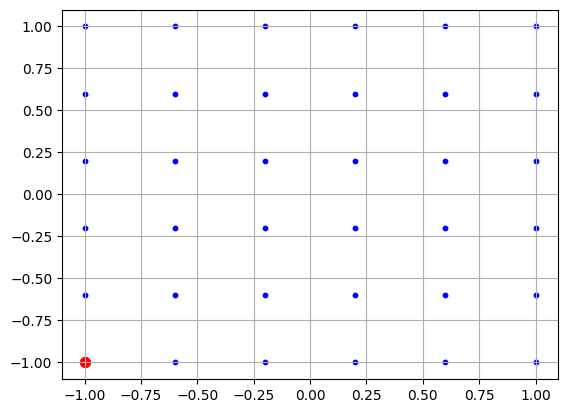

In [2]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(6)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(6)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [3]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(38, 38)


In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421738
Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu


In [5]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == 1 for i in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [6]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)

    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [7]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 2.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [8]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [9]:
# import datetime
def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)

        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()

    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)

    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    # fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png")
    plt.show()

In [10]:
import gurobipy as grb

class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    selected_nodes = None

    def __init__(self, model):
        self.model = model
        MILPSolver.selected_nodes = []
        
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

            # If this solution's maximum costing tour ~= the cost of the tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 26286 rows, 17367 columns and 141378 nonzeros
Model fingerprint: 0xef10a2f5
Variable types: 39 continuous, 17328 integer (8664 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 2078 rows and 458 columns
Presolve time: 0.23s
Presolved: 24208 rows, 16909 columns, 137842 nonzeros
Variable types: 37 continuous, 16872 integer (8436 binary)
Found a new solution with lower cost(113.478)!


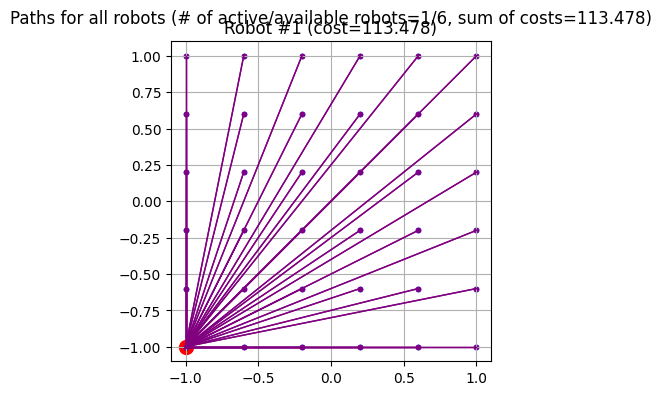

Found heuristic solution: objective 113.4784011
Found a new solution with lower cost(58.420)!


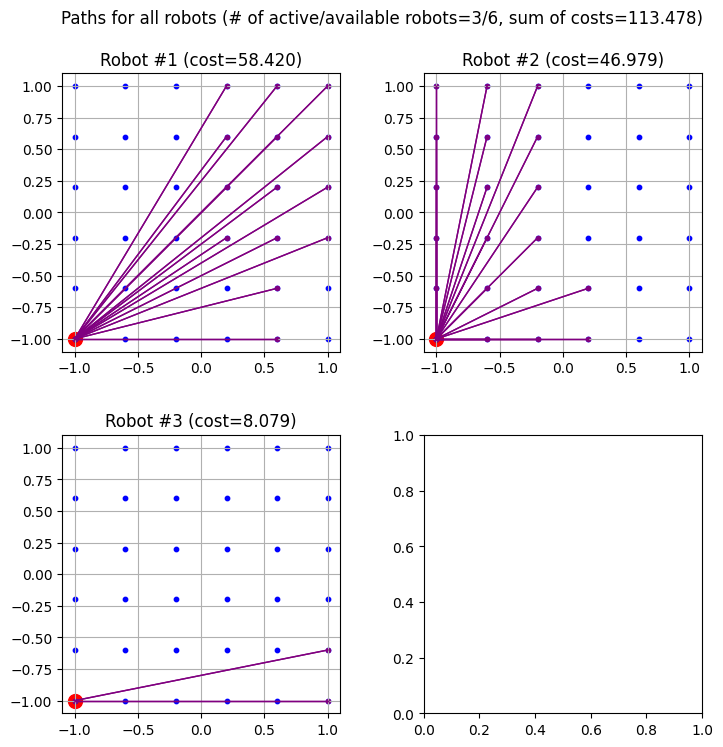

Found heuristic solution: objective 58.4197381
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...
Concurrent spin time: 0.01s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 2.398915e+00, 5102 iterations, 0.21 seconds (0.25 work units)
Total elapsed time = 6.54s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.39892    0  279   58.41974    2.39892  95.9%     -   10s
Found a new solution with lower cost(21.061)!


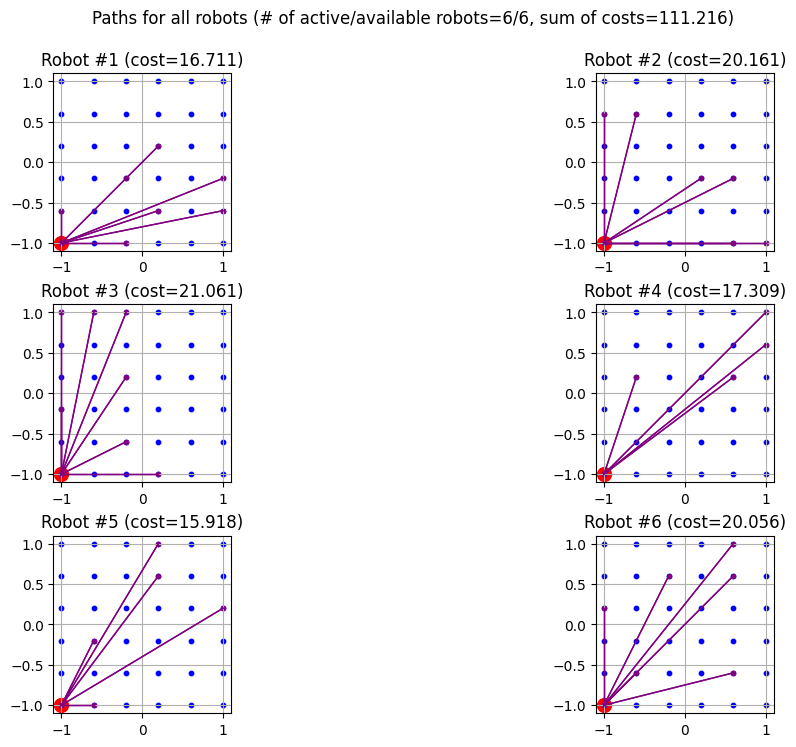

H    0     0                      21.0606429    2.39892  88.6%     -   12s
Found a new solution with lower cost(15.999)!


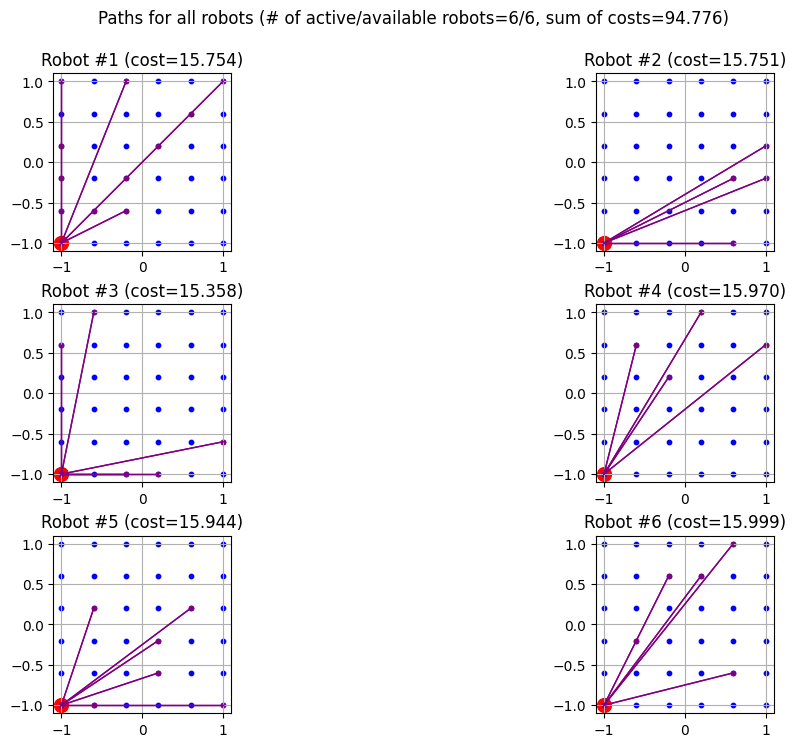

H    0     0                      15.9986927    2.39892  85.0%     -   16s
     0     0    2.39892    0  304   15.99869    2.39892  85.0%     -   16s
Found a new solution with lower cost(10.417)!


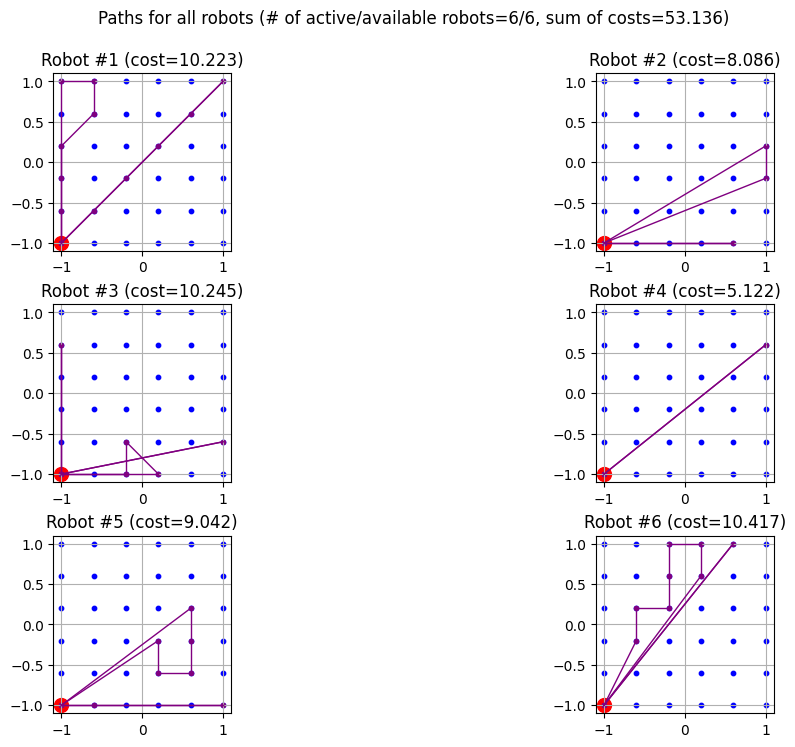

H    0     0                      10.4169266    2.39892  77.0%     -   27s
Found a new solution with lower cost(8.449)!


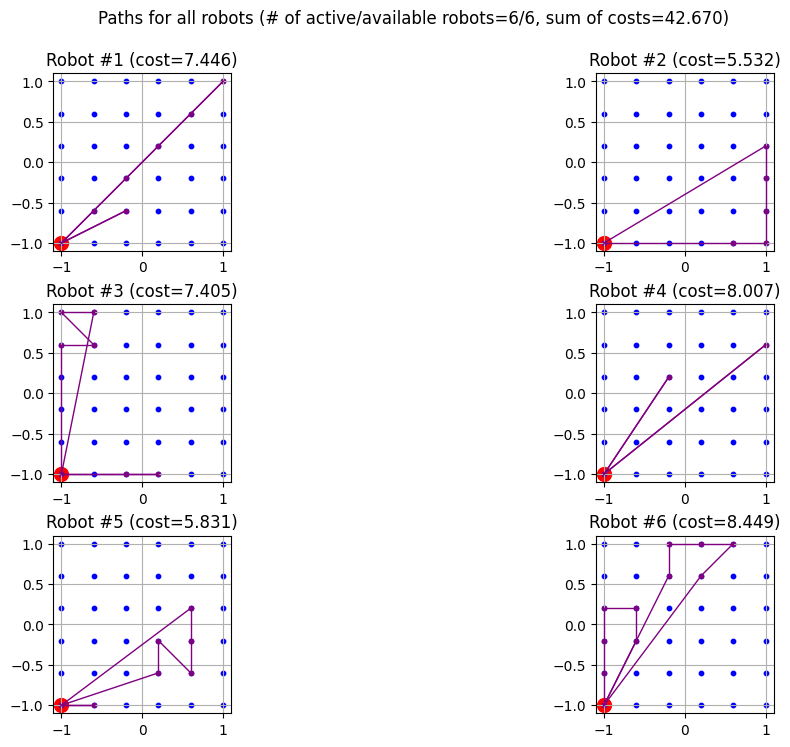

H    0     0                       8.4489670    2.39892  71.6%     -   32s
     0     0    2.39892    0  415    8.44897    2.39892  71.6%     -   32s
     0     0    2.39892    0  462    8.44897    2.39892  71.6%     -   41s
Found a new solution with lower cost(8.445)!


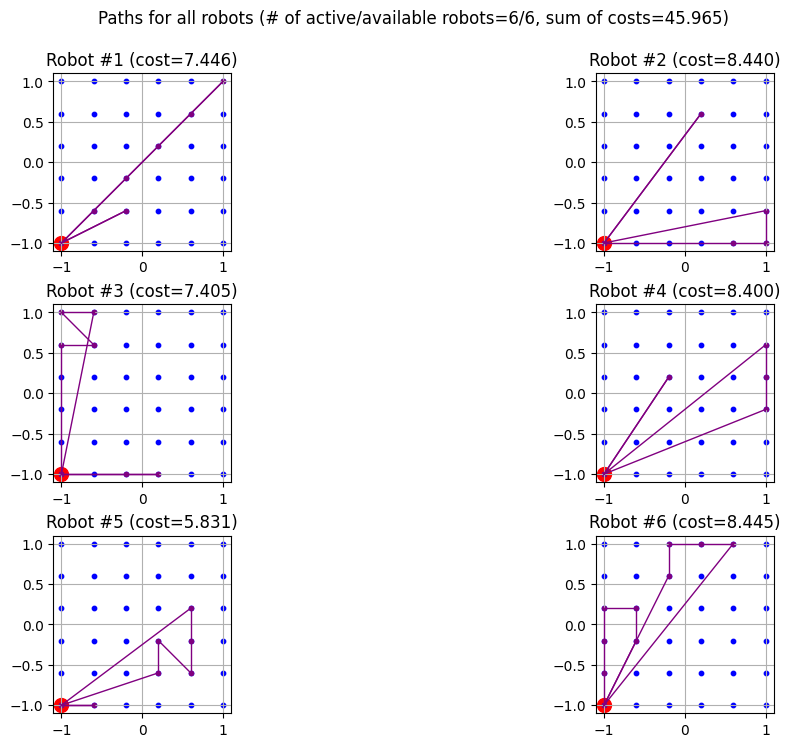

H    0     0                       8.4445313    2.39892  71.6%     -   43s
     0     0    2.39892    0  489    8.44453    2.39892  71.6%     -   46s
     0     0    2.39892    0  275    8.44453    2.39892  71.6%     -   57s
     0     0    2.39892    0  365    8.44453    2.39892  71.6%     -   59s
Found a new solution with lower cost(8.109)!


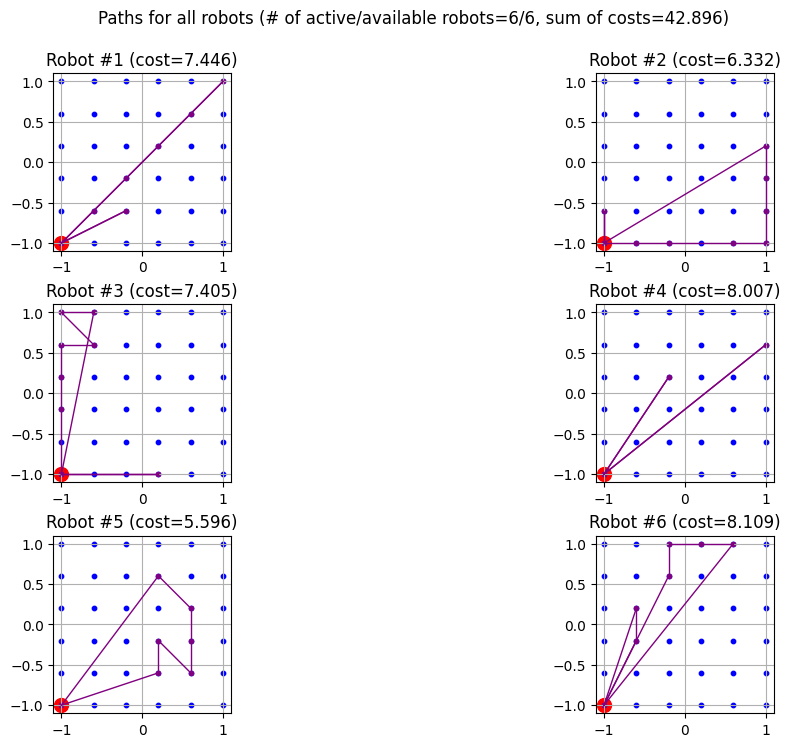

H    0     0                       8.1094423    2.39892  70.4%     -   70s
Found a new solution with lower cost(7.668)!


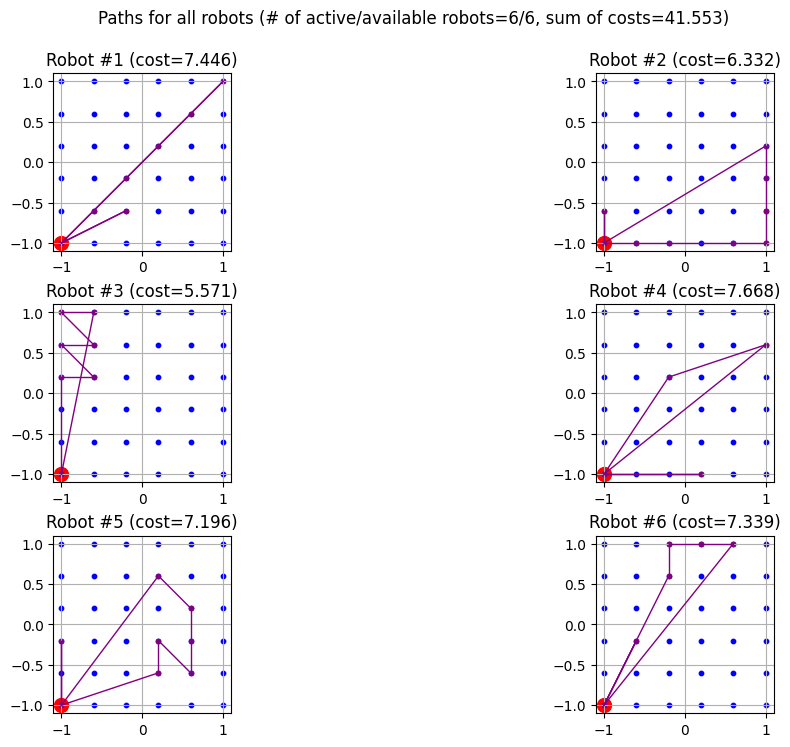

H    0     0                       7.6683813    2.39892  68.7%     -   72s
Found a new solution with lower cost(7.321)!


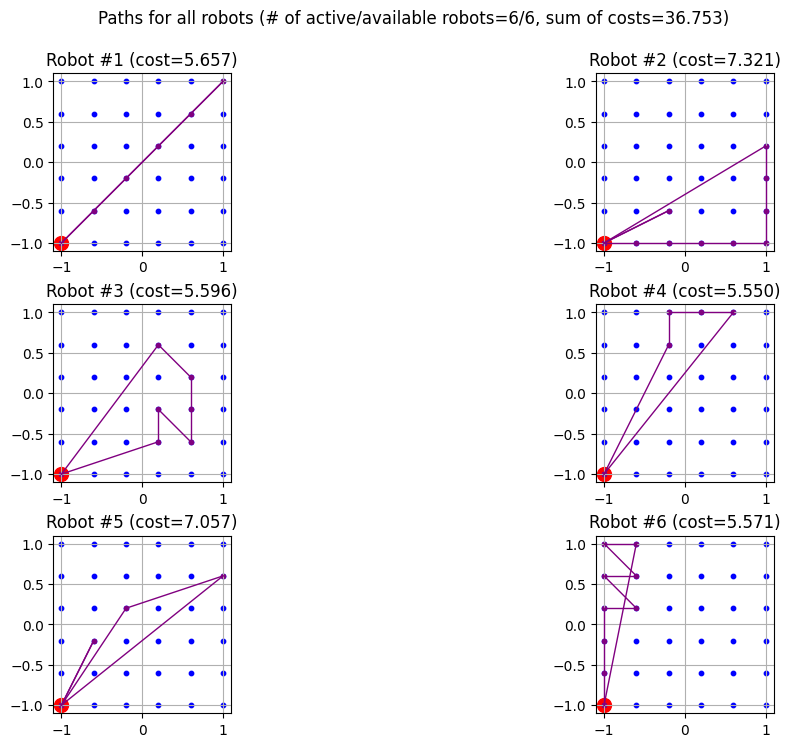

H    0     0                       7.3212347    2.39892  67.2%     -   73s
Found a new solution with lower cost(5.657)!


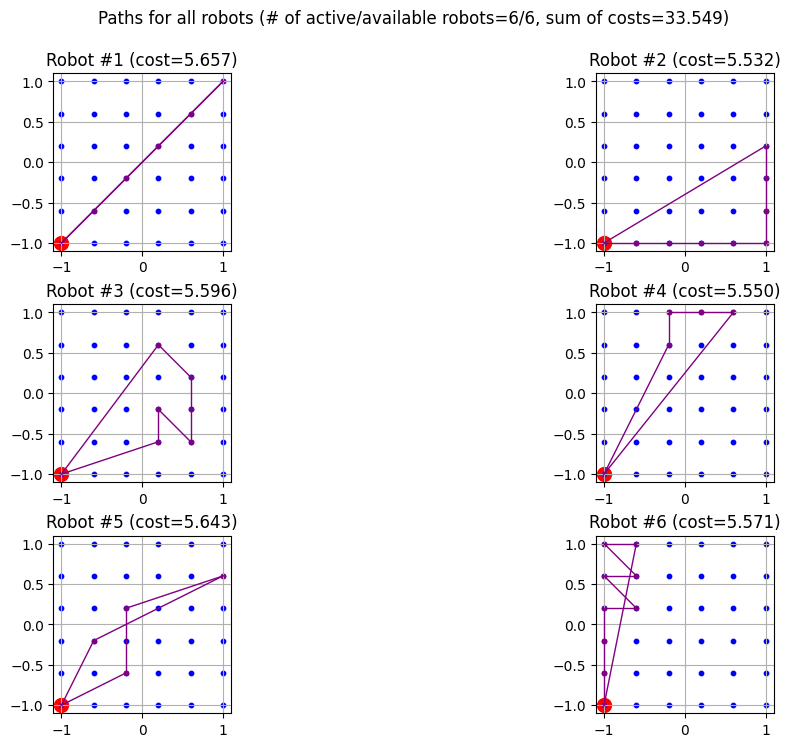

!This is guaranteed to be the optimal solution!
H    0     0                       5.6568542    2.39892  57.6%     -   74s
     0     0    2.39892    0  279    5.65685    2.39892  57.6%     -   74s

Cutting planes:
  Implied bound: 12
  MIR: 153
  StrongCG: 10
  Flow cover: 30
  GUB cover: 1
  Zero half: 5
  RLT: 34

Explored 1 nodes (146298 simplex iterations) in 74.69 seconds (133.98 work units)
Thread count was 20 (of 20 available processors)

Solution count 10: 5.65685 7.32123 7.66838 ... 58.4197

Solve interrupted
Best objective 5.656854249492e+00, best bound 2.398915210301e+00, gap 57.5928%

User-callback calls 5938, time in user-callback 14.16 sec


In [11]:
# Optimize until the first optimal solution is found
m._x = x
solver = MILPSolver(m)
solver.solve()


In [49]:
def calculate_total_distance(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    total_cost += cost_matrix[path[-1], path[0]]  # Return to start
    return total_cost

def two_opt(route, cost_matrix):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue  # Skip adjacent edges
                new_route = route.copy()
                new_route[i:j] = route[j - 1:i - 1:-1]  # Reverse the segment between i and j
                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    return best_route, best_distance

def extract_and_calculate_milp_costs(x, start_nodes, num_robots, num_nodes, cost_matrix):
    milp_costs = []
    milp_paths = []

    for ki in range(num_robots):
        current_node = start_nodes[ki]  # Start at the robot's starting node
        path = [current_node]  # Initialize path with start node
        visited = {current_node}  # Set to keep track of visited nodes

        while len(visited) < num_nodes:
            next_node = np.argmax(x[ki, current_node, :])
            if next_node in visited:
                break  # Avoid revisiting nodes
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node

        milp_paths.append(path)
        milp_costs.append(calculate_path_cost(path, cost_matrix))

    return milp_paths, milp_costs


def visualize_individual_paths(paths, nodes, targets, depots, B_k, costs):
    num_robots = len(paths)
    num_rows = (num_robots + 1) // 2  # Two plots per row
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # Adjust the figure size as needed

    # Flatten the axs array for easy iteration if there's more than one row
    if num_robots > 2:
        axs = axs.flatten()

    for index, path in enumerate(paths):
        ax = axs[index]

        # Plot targets and depots
        ax.scatter(targets[:, 0], targets[:, 1], c='blue', s=10, label='Targets')
        ax.scatter(depots[:, 0], depots[:, 1], c='red', s=50, label='Depots')

        # Plot path for this robot
        for i in range(len(path) - 1):
            start_node = path[i]
            end_node = path[i + 1]
            ax.plot([nodes[start_node, 0], nodes[end_node, 0]],
                    [nodes[start_node, 1], nodes[end_node, 1]],
                    color="purple", linewidth=1)
            ax.scatter(nodes[start_node, 0], nodes[start_node, 1], c="purple", s=8)

        # Plot a line returning to the starting depot
        ax.plot([nodes[path[-1], 0], nodes[B_k[0], 0]],
                [nodes[path[-1], 1], nodes[B_k[0], 1]],
                color="purple", linewidth=1, linestyle="--", label='Return to Depot')

        # Set title with cost
        ax.set_title(f"Robot #{index + 1} (Cost: {costs[index]:.2f})")
        ax.grid()
        ax.legend()

    # Hide any unused subplots
    for i in range(index + 1, num_rows * 2):
        fig.delaxes(axs[i])

    # plt.tight_layout()
    fig.suptitle(f"Paths for all robots (sum of costs={sum(costs):.3f})")
    plt.show()

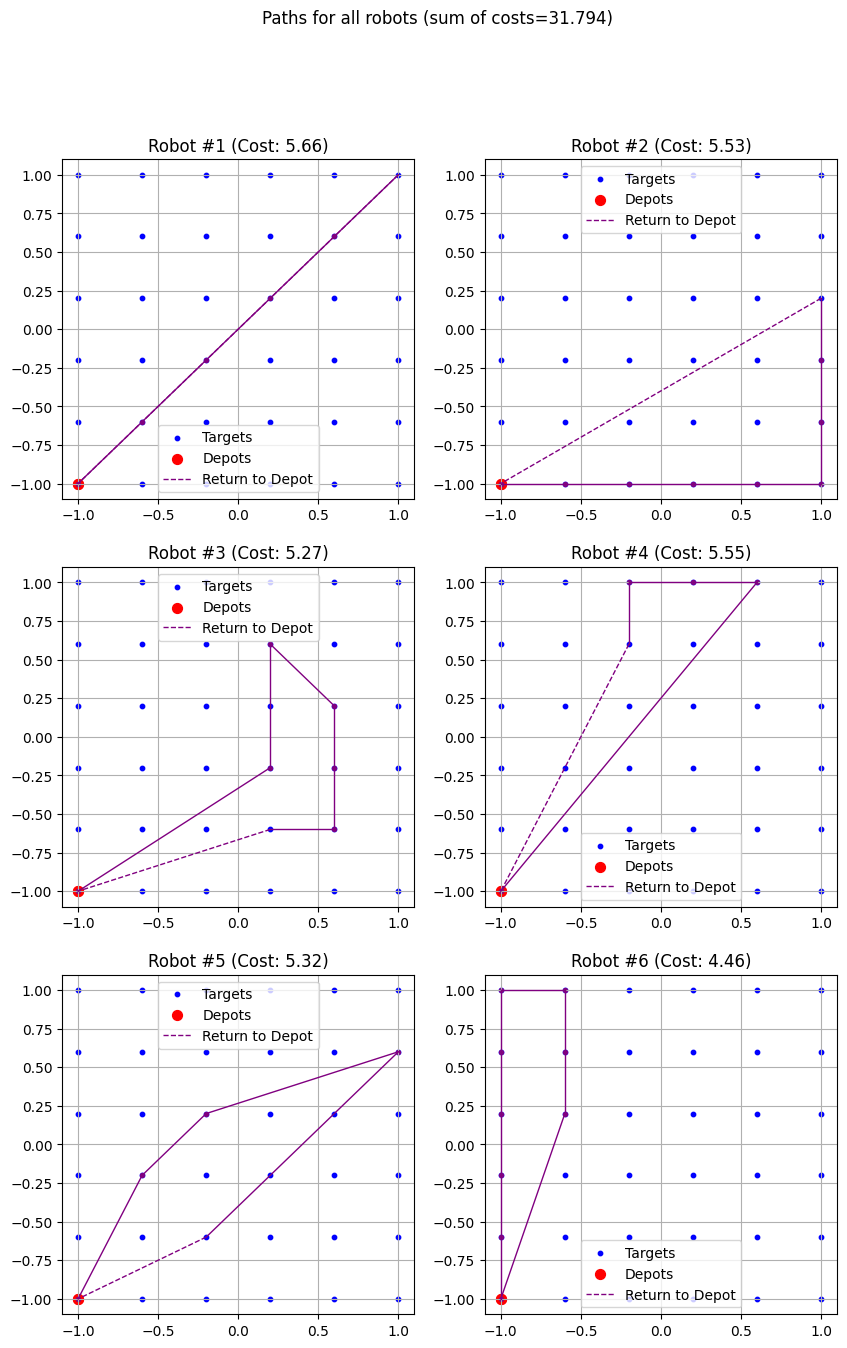

In [53]:
milp_solution_x = np.array([x[ki].X for ki in range(k)]).reshape(k, len(node_indices), len(node_indices))
milp_paths, milp_costs = extract_and_calculate_milp_costs(milp_solution_x, B_k, k, len(node_indices), cost)

# Apply 2-opt algorithm to each path -> iteratively remove two edges and reconnect the two paths in a different way that reduces the total distance.
optimized_paths = [] # Initialize an empty list to store optimized paths
for path in milp_paths:
    opt_path, opt_dist = two_opt(path, cost)
    optimized_paths.append(opt_path)

def calculate_path_cost(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    # Add cost of returning to the starting depot
    total_cost += cost_matrix[path[-1], path[0]]
    return total_cost

# Calculate costs for each robot
optimized_costs = [calculate_path_cost(path, cost) for path in optimized_paths]

# Call the updated visualization function with costs
visualize_individual_paths(optimized_paths, nodes, targets, depots, B_k, optimized_costs)

In [51]:
# Calculate cost reduction for each robot
for index, (milp_cost, opt_cost) in enumerate(zip(milp_costs, optimized_costs)):
    cost_reduction = milp_cost - opt_cost
    print(f"Cost reduction for Robot {index + 1}: {cost_reduction:.2f}")


Cost reduction for Robot 1: 0.00
Cost reduction for Robot 2: 0.00
Cost reduction for Robot 3: 0.32
Cost reduction for Robot 4: 0.00
Cost reduction for Robot 5: 0.33
Cost reduction for Robot 6: 1.11
